In [1]:
using Plots
using Revise
# include project utilities
includet("choques_utils.jl")
# complementary_utils.jl is included so its TVD routines are available if you want to call them.

includet("complementary_utils.jl")



In [2]:
# Grid setup
    n = 100
    L = 2π
    dx = L / n
    x_centers = ((0:n-1) .* dx) .+ dx/2
    
    # Parameters for evolution
    η = 0.01  # viscosity parameter
    dt = 0.1 * dx  # CFL-based timestep
    t_final = 10.
    
    # Initial condition: smooth bump
    u0 = @. exp(-(x_centers - L/2)^2 * 4)
    u = copy(u0)
    u_ext = similar(u, n + 6)  # for ghost cells if needed
    u_ext[4:end-3] = u  # fill interior cells
    u_ext[1:3] .= u0[end-2:end]  # left ghost cells (periodic)
    u_ext[end-2:end] .= u0[1:3]  # right
    
    # Arrays for WENO reconstruction
    #uL = zeros(n)
    #uR = zeros(n)
    #duL = zeros(n)
    #duR = zeros(n)
    #uxL = zeros(n)
    #uxR = zeros(n)
    #duxL = zeros(n)
    #duxR = zeros(n)
    du = zeros(n)
    
    # RHS function for Burgers equation with viscosity
    function burgers_rhs_Per!(du, u, t, params)
        dx, η = params
        
        # Reconstruct u and u_x at interfaces
        uL, uR, duL, duR = WENOZ_FV_reconstruct_from_averages_Per(u, dx)
        
        # Compute fluxes at interfaces
        fL = 0.5 * uL.^2 + η * duL
        fR = 0.5 * uR.^2 + η * duR
        
        # Simple Rusanov flux
        λ = maximum(abs.(u))
        fnum =  0.5 * (fL + fR - λ * (uR - uL))
        
        # Update cell averages
        du[:] = -(fnum - circshift(fnum, -1)) / dx
        
        return nothing
    end

    function burgers_rhs_Per(u, t, params)
        dx, η, du = params
        #du = zeros(length(u))
        burgers_rhs_Per!(du, u, t, (dx, η))
        return du
    end

    # Time evolution with TVD3
    t = 0.0
    params = (dx, η, du)
    nsteps = round(Int, t_final/dt)
    
    # Basic tests before evolution
    @show length(u) == n
    @show maximum(abs.(u .- u0)) < 1e-14
    
    # Evolve (f,y0,t0,h,pf)
    max_u = zeros(nsteps)
    int_u = zeros(nsteps)

    for i in 1:nsteps
        TVD3_Step!(burgers_rhs_Per, u, t, dt, params)
        println("t = $t, max_u = $(maximum(u)), int_u = $(sum(u)*dx)")
        max_u[i] = maximum(u)
        int_u[i] = sum(u)*dx

        t += dt
    end
    
    # Basic sanity checks after evolution
    @show !any(isnan.(u))  # No NaNs
    @show maximum(abs.(u)) ≤ maximum(abs.(u0)) * 1.1  # Max principle approximately
    @show isapprox(sum(u) * dx, sum(u0) * dx,  rtol=1e-3)  # Mass conservation


length(u) == n = true
maximum(abs.(u .- u0)) < 1.0e-14 = true
t = 0.0, max_u = 0.9940048002433289, int_u = 0.886226925452758
t = 0.0062831853071795875, max_u = 0.991772456761108, int_u = 0.8862269254527579
t = 0.012566370614359175, max_u = 0.9893748967241113, int_u = 0.886226925452758
t = 0.018849555921538762, max_u = 0.9868234637869202, int_u = 0.886226925452758
t = 0.02513274122871835, max_u = 0.9841288897959636, int_u = 0.886226925452758
t = 0.031415926535897934, max_u = 0.981301325007837, int_u = 0.8862269254527579
t = 0.03769911184307752, max_u = 0.9783503670962016, int_u = 0.886226925452758
t = 0.0439822971502571, max_u = 0.975285088518082, int_u = 0.886226925452758
t = 0.050265482457436686, max_u = 0.9721140621673706, int_u = 0.886226925452758
t = 0.05654866776461627, max_u = 0.9688453856708747, int_u = 0.886226925452758
t = 0.06283185307179585, max_u = 0.9654867048227591, int_u = 0.886226925452758
t = 0.06911503837897544, max_u = 0.9620452364376871, int_u = 0.886226925452758
t 

true

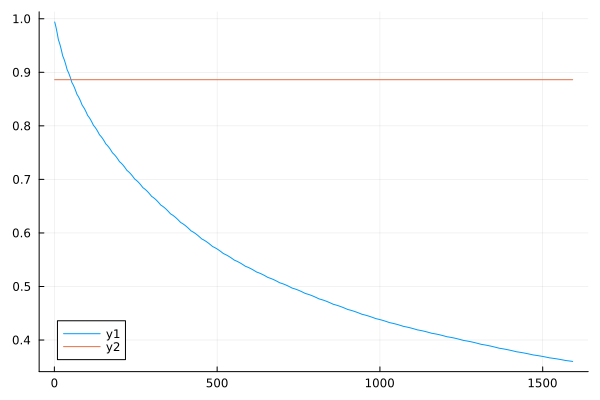

In [3]:
plot(max_u)
plot!(int_u)

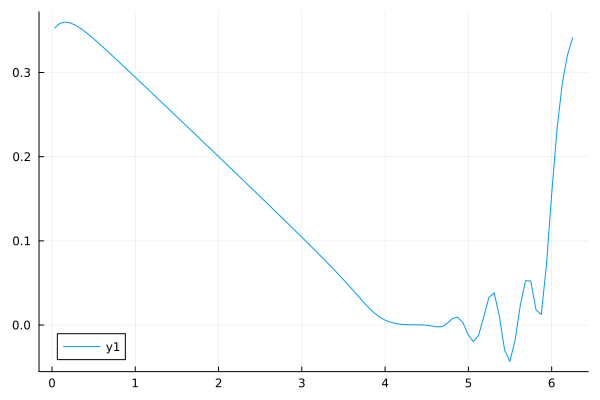

In [4]:
plot(x_centers,u)

In [15]:
#plot(burgers_rhs!(du, u, t, (dx, η)))
#plot(du)

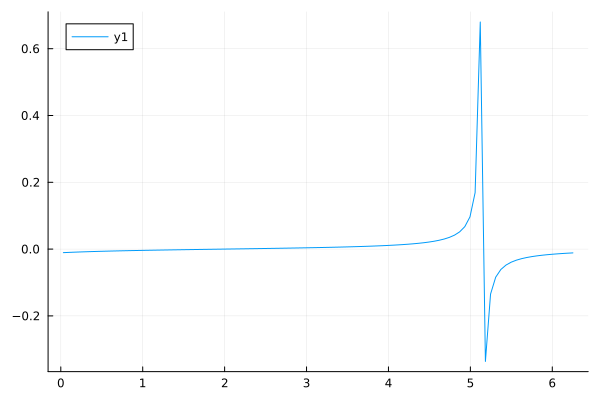

In [16]:
function s(x,par) 
  η, c, k = par
  return sqrt(c/2)*tan(c/2/η^2*(x + k))
end

par = (-η, η^2, -2)
sp(x) = s(x,par)
plot(x_centers,sp.(x_centers))